## STL Conversion to Individual Graph Files

In [1]:
# Imports
import os
import json
import glob
import torch
from torch_geometric.data import Data
import trimesh
from torch_geometric.data import DataLoader

In [2]:
def stl_to_graph(file_path):
    # Load the mesh
    mesh = trimesh.load_mesh(file_path)
    
    # Extract vertices and faces
    vertices = mesh.vertices  # NumPy array of shape (num_vertices, 3)
    faces = mesh.faces  # NumPy array of shape (num_faces, 3)
    
    # Convert vertices to tensor
    x = torch.tensor(vertices, dtype=torch.float)
    
    # Build edge_index from faces
    edge_index = build_edge_index(faces)
    
    # Create graph data object
    data = Data(x=x, edge_index=edge_index)
    return data

def build_edge_index(faces):
    # Extract edges from faces
    edges = []
    for face in faces:
        v1, v2, v3 = face
        # Add edges (both directions for undirected graphs)
        edges.extend([[v1, v2], [v2, v1],
                      [v2, v3], [v3, v2],
                      [v3, v1], [v1, v3]])
    # Convert to tensor and remove duplicate edges
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_index = torch.unique(edge_index, dim=1)
    return edge_index

#### Analyze QS Distribution

In [28]:
import json
import matplotlib.pyplot as plt
import numpy as np

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Extract QS values with clipping between 0 and 500
def extract_qs(data):
    qs_values = np.array([float(value) for value in data.values()])
    qs_values = np.clip(qs_values, 0, 500)
    return qs_values

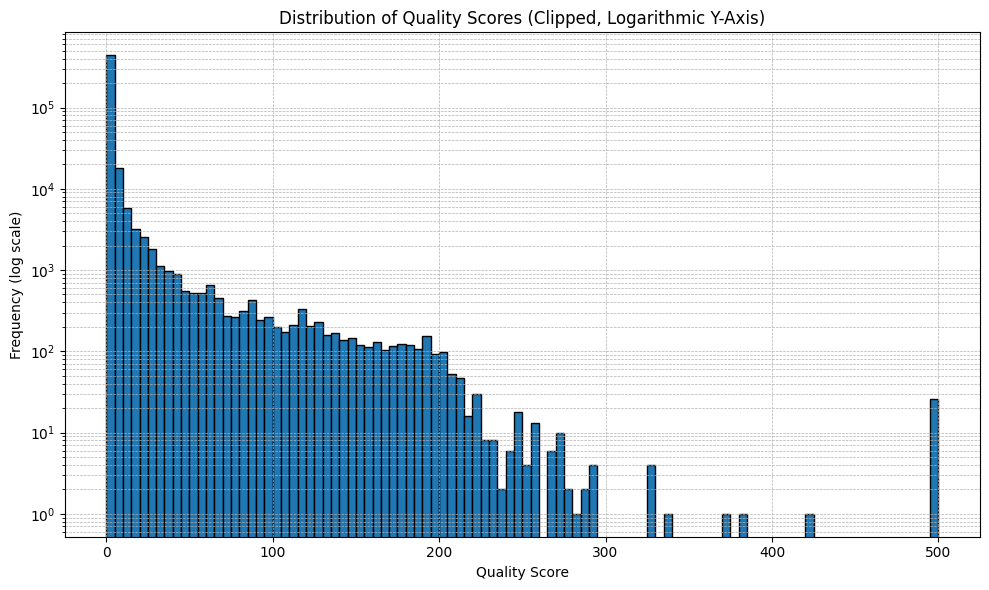

In [30]:
# Plot Log Scale
def plot_qs_distribution_log_y(qs_values):
    min_qs = 0
    max_qs = 500
    bins = 100  # Adjust as needed

    plt.figure(figsize=(10, 6))
    plt.hist(qs_values, bins=bins, range=(min_qs, max_qs), edgecolor='black')
    plt.xlabel('Quality Score')
    plt.ylabel('Frequency (log scale)')
    plt.title('Distribution of Quality Scores (Clipped, Logarithmic Y-Axis)')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

file_path = '../../data/labels/stl.json'
data = load_json(file_path)
qs_values = extract_qs(data)
plot_qs_distribution_log_y(qs_values)

Min quality score (after clipping): 0
Max quality score (after clipping): 50


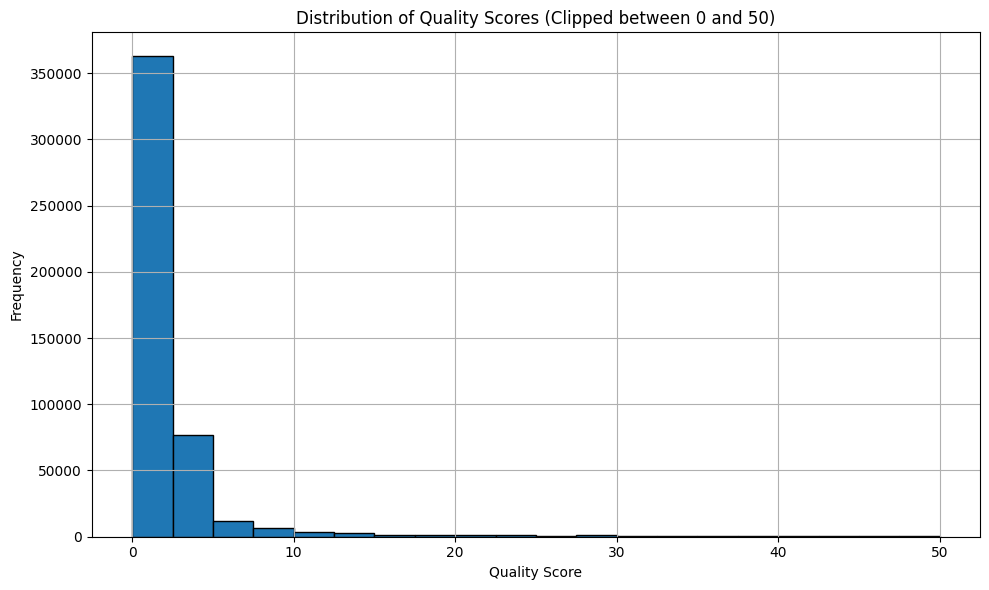

In [38]:
def plot_qs_distribution(qs_values):
    min_qs = 0
    max_qs = 50
    print(f"Min quality score (after clipping): {min_qs}")
    print(f"Max quality score (after clipping): {max_qs}")

    bins = 20  # Adjust the number of bins as needed

    plt.figure(figsize=(10, 6))
    plt.hist(qs_values, bins=bins, range=(min_qs, max_qs), edgecolor='black')
    plt.xlabel('Quality Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Quality Scores (Clipped between 0 and 50)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_qs_distribution(qs_values)

In [39]:
print(f"Min: {min(qs_values)}")
print(f"Max: {max(qs_values)}")
print(f"Mean: {np.mean(qs_values)}")
print(f"Standard Deviation: {np.std(qs_values)}")

Min: 0.002276647336207848
Max: 500.0
Mean: 4.419927292436336
Standard Deviation: 15.373681091223833


#### Processing

In [ ]:
with open('../../data/labels/stl.json', 'r') as f:
    quality_scores = json.load(f)

# Convert string quality scores to floats
for key in quality_scores:
    quality_scores[key] = float(quality_scores[key])

In [ ]:
# TODO: Normalize Quality Scores
import os

def standardize_filename(file_path):
    return os.path.basename(file_path)

quality_scores_standardized = {
    standardize_filename(k): v for k, v in quality_scores.items()
}

Save individual graphs in PT format

In [ ]:
stl_files_directory = '../../data/fulldata/'
output_directory = '../../data/processed/processed_graphs/'
os.makedirs(output_directory, exist_ok=True)

stl_files = glob.glob(os.path.join(stl_files_directory, '**', '*.stl'), recursive=True)

for file_path in stl_files:
    filename = os.path.basename(file_path)
    if filename in quality_scores_standardized:
        quality_score = quality_scores_standardized[filename]
        try:
            # Convert STL to graph
            graph = stl_to_graph(file_path)
            # Add the quality score as the target label
            graph.y = torch.tensor([quality_score], dtype=torch.float)
            # Save the graph to disk individually
            torch.save(graph, os.path.join(output_directory, filename + '.pt'))
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    else:
        print(f"No quality score for {file_path}")